### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import winsorize
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visual style for plots
sns.set(style="whitegrid")

function for downcasting, and we will need for optimization

In [3]:
def downcaste_dtype(df):
    previous_memory_consumption = (df.memory_usage().sum()) / 1024**2 
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype != 'object':
            xmin = df[col].min()
            xmax = df[col].max()
            if str(col_dtype)[0] == 'i': 
                if np.iinfo('int8').min < xmin and np.iinfo('int8').max > xmax:
                    df[col] = df[col].astype('int8')
                elif np.iinfo('int16').min < xmin and np.iinfo('int16').max > xmax:
                    df[col] = df[col].astype('int16')
                elif np.iinfo('int32').min < xmin and np.iinfo('int32').max > xmax:
                    df[col] = df[col].astype('int32')
                elif np.iinfo('int64').min < xmin and np.iinfo('int64').max > xmax:
                    df[col] = df[col].astype('int64')
                    
            elif str(col_dtype)[0] == 'f': 
                if np.finfo('float16').min < xmin and np.finfo('float16').max > xmax:
                    df[col] = df[col].astype('float16')
                elif np.finfo('float32').min < xmin and np.finfo('float32').max > xmax:
                    df[col] = df[col].astype('float32')
                elif np.finfo('float64').min < xmin and np.finfo('float64').max > xmax:
                    df[col] = df[col].astype('float64')
            else:
                pass

    after_memory_consumption = (df.memory_usage().sum()) / 1024**2
    percentage_of_decrease = ((previous_memory_consumption - after_memory_consumption) / previous_memory_consumption) * 100

    print('Memory usage before downcasting: {:.2f} MB'.format(previous_memory_consumption))
    print('After Downcasting the memory usage decreased to: {:.2f} MB'.format(after_memory_consumption))
    print('Memory usage decreased by {:.3f}%'.format(percentage_of_decrease))

    return df

### Loading Data

In [4]:
loan_applications = pd.read_csv('../DataSet/loan_applications_train.csv')
previous_credits = pd.read_csv('../DataSet/previous_credits.csv')
credit_bureau_balance = pd.read_csv('../DataSet/credit_bureau_balance.csv')
previous_loan_applications = pd.read_csv('../DataSet/previous_loan_applications.csv')
repayment_history = pd.read_csv('../DataSet/repayment_history.csv')
pos_cash_loans = pd.read_csv('../DataSet/previous_pos_cash_loans.csv')
credit_cards = pd.read_csv('../DataSet/previous_credit_cards.csv')

In [5]:
# optimizing
loan_applications = downcaste_dtype(loan_applications)
previous_credits = downcaste_dtype(previous_credits)
credit_bureau_balance = downcaste_dtype(credit_bureau_balance)
previous_loan_applications = downcaste_dtype(previous_loan_applications)
repayment_history = downcaste_dtype(repayment_history)
pos_cash_loans = downcaste_dtype(pos_cash_loans)
credit_cards = downcaste_dtype(credit_cards)

Memory usage before downcasting: 286.23 MB
After Downcasting the memory usage decreased to: 92.38 MB
Memory usage decreased by 67.725%
Memory usage before downcasting: 222.62 MB
After Downcasting the memory usage decreased to: 112.95 MB
Memory usage decreased by 49.265%
Memory usage before downcasting: 624.85 MB
After Downcasting the memory usage decreased to: 338.46 MB
Memory usage decreased by 45.833%
Memory usage before downcasting: 471.48 MB
After Downcasting the memory usage decreased to: 309.01 MB
Memory usage decreased by 34.459%
Memory usage before downcasting: 830.41 MB
After Downcasting the memory usage decreased to: 311.40 MB
Memory usage decreased by 62.500%
Memory usage before downcasting: 610.43 MB
After Downcasting the memory usage decreased to: 238.45 MB
Memory usage decreased by 60.937%
Memory usage before downcasting: 673.88 MB
After Downcasting the memory usage decreased to: 289.33 MB
Memory usage decreased by 57.065%


# EDA, Data Cleaning and Feature Engineering

# 1. Applicant Profile Section

Distribution of key numerical features

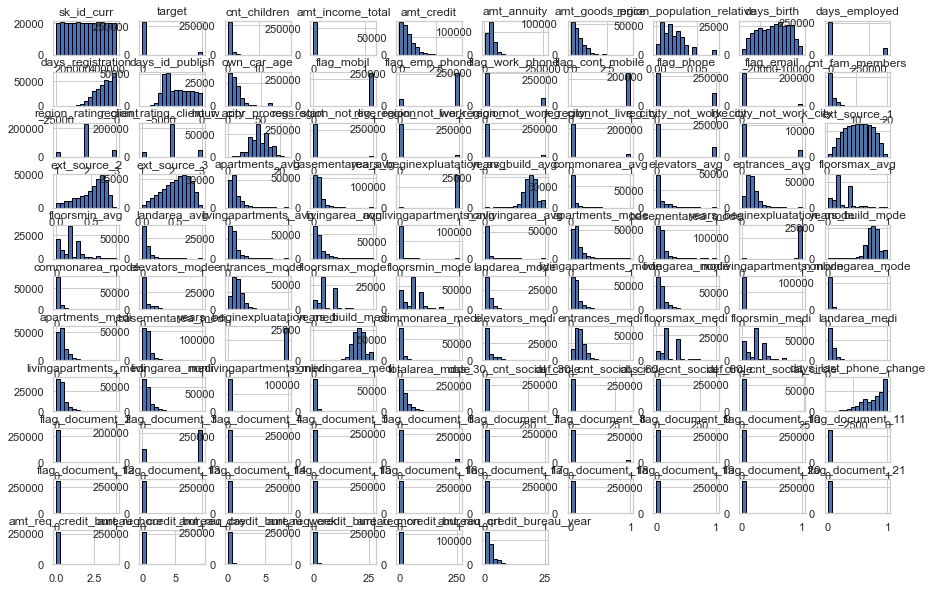

In [6]:
loan_applications.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

Pair Plot for selected features

Text(0.5, 0.98, 'Pairwise Plots of Key Features')

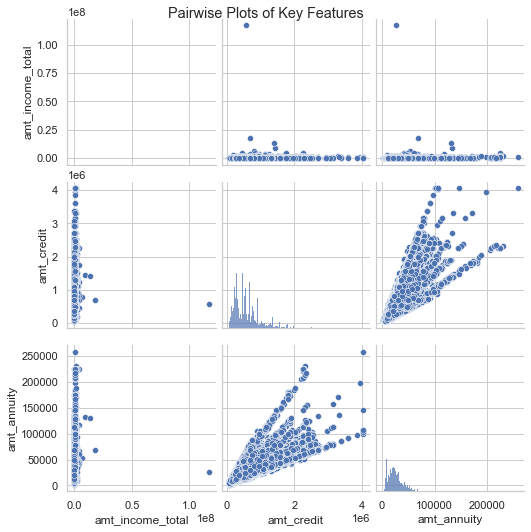

In [7]:
selected_features = ['amt_income_total', 'amt_credit', 'amt_annuity']
sns.pairplot(loan_applications[selected_features])
plt.suptitle('Pairwise Plots of Key Features')

Gender distribution

Text(0.5, 1.0, 'Gender Distribution')

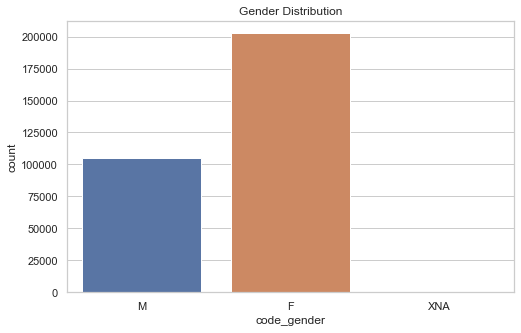

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(x='code_gender', data=loan_applications)
plt.title('Gender Distribution')

Income distribution (with log transformation for better visualization)

Text(0, 0.5, 'Frequency')

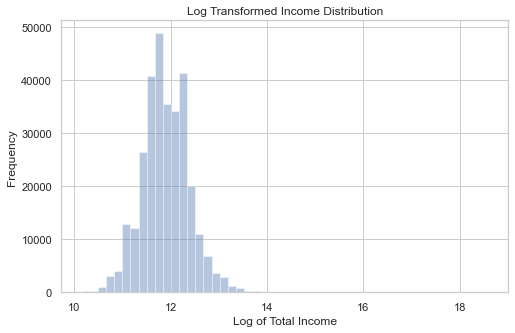

In [9]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log1p(loan_applications['amt_income_total']), kde=False)
plt.title('Log Transformed Income Distribution')
plt.xlabel('Log of Total Income')
plt.ylabel('Frequency')

Boxplot for income by gender

Text(0.5, 1.0, 'Income Distribution by Gender')

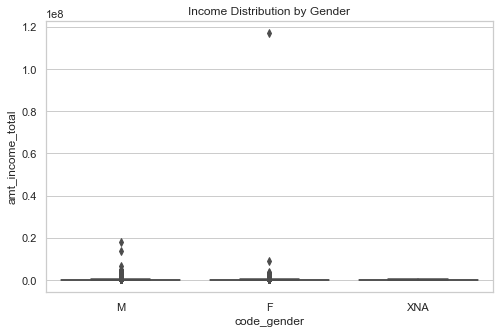

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='code_gender', y='amt_income_total', data=loan_applications)
plt.title('Income Distribution by Gender')

Income vs Loan Amount with Hue for Contract Type

Text(0, 0.5, 'Credit Amount')

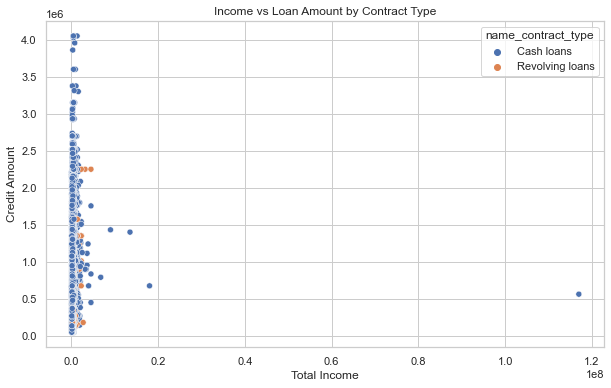

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amt_income_total', y='amt_credit', hue='name_contract_type', data=loan_applications)
plt.title('Income vs Loan Amount by Contract Type')
plt.xlabel('Total Income')
plt.ylabel('Credit Amount')

Average income by contract type

In [12]:
avg_income_by_contract = loan_applications.groupby('name_contract_type')['amt_income_total'].mean()

KDE Plot of Age for different Contract Types

In [13]:
# plt.figure(figsize=(10, 6))
# for contract_type in loan_applications['name_contract_type'].unique():
#     subset = loan_applications[loan_applications['name_contract_type'] == contract_type]
#     sns.kdeplot(subset['age_years'], label=contract_type)
# plt.title('Age Distribution by Contract Type')
# plt.xlabel('Age in Years')
# plt.ylabel('Density')

Z-Score for Income, for outlier detection

In [14]:
loan_applications['income_z_score'] = np.abs(stats.zscore(loan_applications['amt_income_total']))
outliers = loan_applications[loan_applications['income_z_score'] > 3]
outliers

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,income_z_score
1504,101769,0,Revolving loans,M,Y,Y,0,1080000.0,180000.0,9000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.842744
1723,102015,0,Cash loans,F,N,Y,0,1935000.0,269550.0,10534.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.448472
3371,103938,0,Cash loans,F,N,N,1,1350000.0,2410380.0,109053.0,...,0,0,0,0.0,0.0,0.0,3.0,0.0,0.0,4.981396
4603,105384,0,Revolving loans,F,Y,Y,0,1350000.0,405000.0,20250.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.981396
5673,106637,0,Cash loans,M,Y,Y,3,967500.0,450000.0,30073.5,...,0,0,0,0.0,0.0,0.0,1.0,1.0,0.0,3.368307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304477,452764,0,Cash loans,F,Y,Y,1,2025000.0,935640.0,93487.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.828022
305577,454039,0,Cash loans,M,Y,Y,0,1215000.0,1264738.5,67513.5,...,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0,4.412070
306028,454569,0,Revolving loans,M,Y,Y,0,1350000.0,1575000.0,78750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.981396
306179,454746,0,Cash loans,M,Y,Y,1,949500.0,735579.0,35518.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.292397


##### Data Cleaning and Feature Engineering

In [15]:
# Using SimpleImputer 
imputer = SimpleImputer(strategy='mean')
numerical_cols = loan_applications.select_dtypes(include=[np.number]).columns
loan_applications[numerical_cols] = imputer.fit_transform(loan_applications[numerical_cols])

In [16]:
# Handling missing values for categorical columns with mode imputation
categorical_cols = loan_applications.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    loan_applications[col].fillna(loan_applications[col].mode()[0], inplace=True)

In [17]:
# Handling missing values for categorical columns with mode imputation
categorical_cols = loan_applications.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    loan_applications[col].fillna(loan_applications[col].mode()[0], inplace=True)

In [18]:
# Feature Engineering

# Income Ratios
loan_applications['credit_income_ratio'] = loan_applications['amt_credit'] / loan_applications['amt_income_total']
loan_applications['annuity_income_ratio'] = loan_applications['amt_annuity'] / loan_applications['amt_income_total']
loan_applications['goods_price_income_ratio'] = loan_applications['amt_goods_price'] / loan_applications['amt_income_total']

# Career Ratio
loan_applications['employment_ratio'] = loan_applications['days_employed'] / loan_applications['days_birth']
loan_applications['employment_ratio'] = loan_applications['employment_ratio'].replace([np.inf, -np.inf], np.nan)

# Family Features
loan_applications['adults_ratio'] = (loan_applications['cnt_fam_members'] - loan_applications['cnt_children']) / loan_applications['cnt_fam_members']

# Number of Overall Payments
loan_applications['payment_rate'] = loan_applications['amt_credit'] / loan_applications['amt_annuity'].replace({0: np.nan})

# External Source Features
loan_applications['ext_sources_mean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].mean(axis=1)
loan_applications['ext_sources_nanmean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].apply(lambda x: np.nanmean(x), axis=1)

# Number of Documents Submitted
doc_vars = ["flag_document_" + str(i) for i in range(2, 22)]
loan_applications['doc_count'] = loan_applications[doc_vars].sum(axis=1)

# Logarithm Transformation of Skewed Features
skewed_cols = ['amt_credit', 'amt_income_total', 'amt_goods_price', 'amt_annuity']
for col in skewed_cols:
    loan_applications['log_' + col] = np.log1p(loan_applications[col])

# Convert Days to Years
days_cols = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish', 'days_last_phone_change']
for col in days_cols:
    loan_applications[col + '_years'] = np.abs(loan_applications[col]) / 365

# Age-Related Ratios
loan_applications['car_age_ratio'] = loan_applications['own_car_age'] / loan_applications['days_birth']
loan_applications['phone_change_ratio'] = loan_applications['days_last_phone_change'] / loan_applications['days_birth']


In [19]:
# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = ohe.fit_transform(loan_applications[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names(categorical_cols))
loan_applications = loan_applications.drop(columns=categorical_cols).join(encoded_features_df)

In [20]:
# Winsorization to cap outliers
for col in numerical_cols:
    loan_applications[col] = winsorize(loan_applications[col], limits=[0.05, 0.05])

In [21]:
loan_applications.isnull().sum().sum()

0

# 2. Credit History Section

In [22]:
# merging data fror this section
merged_data = pd.merge(previous_credits, credit_bureau_balance, on='sk_id_bureau', how='left')

Text(0.5, 1.0, 'Average Credit Amount by Credit Status and Activity')

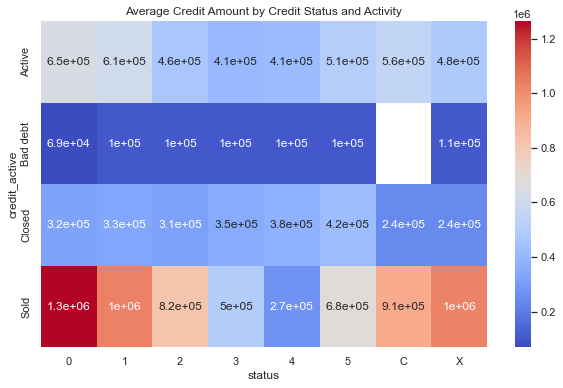

In [23]:
# Heatmap for Credit Amount vs. Status
pivot_table = merged_data.pivot_table(values='amt_credit_sum', index='credit_active', columns='status', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Average Credit Amount by Credit Status and Activity')

Text(0.5, 1.0, 'Correlation Matrix')

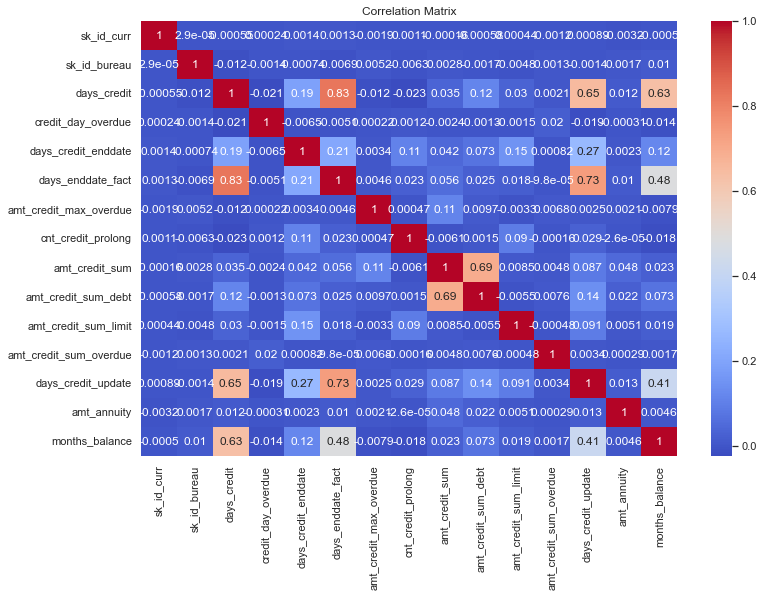

In [24]:
# Correlation analysis
correlation_matrix = merged_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [25]:
# Average credit amount by credit type
avg_credit_by_type = merged_data.groupby('credit_type')['amt_credit_sum'].mean()

# Total credit amount by credit active status
total_credit_by_status = merged_data.groupby('credit_active')['amt_credit_sum'].sum()

# Count of credits by credit type and active status
count_credits = merged_data.groupby(['credit_type', 'credit_active']).size().reset_index(name='count')

# Average monthly balance by status
avg_monthly_balance_by_status = credit_bureau_balance.groupby('status')['months_balance'].mean()

# Maximum overdue amount in credit bureau data
max_overdue = previous_credits.groupby('sk_id_bureau')['amt_credit_max_overdue'].max()

# Multi-level aggregation
agg_data = previous_credits.groupby('credit_active').agg({'amt_credit_sum': 'mean', 
                                                         'amt_credit_max_overdue': 'max'}).reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Another type of loan'),
  Text(1, 0, 'Car loan'),
  Text(2, 0, 'Cash loan (non-earmarked)'),
  Text(3, 0, 'Consumer credit'),
  Text(4, 0, 'Credit card'),
  Text(5, 0, 'Interbank credit'),
  Text(6, 0, 'Loan for business development'),
  Text(7, 0, 'Loan for purchase of shares (margin lending)'),
  Text(8, 0, 'Loan for the purchase of equipment'),
  Text(9, 0, 'Loan for working capital replenishment'),
  Text(10, 0, 'Microloan'),
  Text(11, 0, 'Mobile operator loan'),
  Text(12, 0, 'Mortgage'),
  Text(13, 0, 'Real estate loan'),
  Text(14, 0, 'Unknown type of loan')])

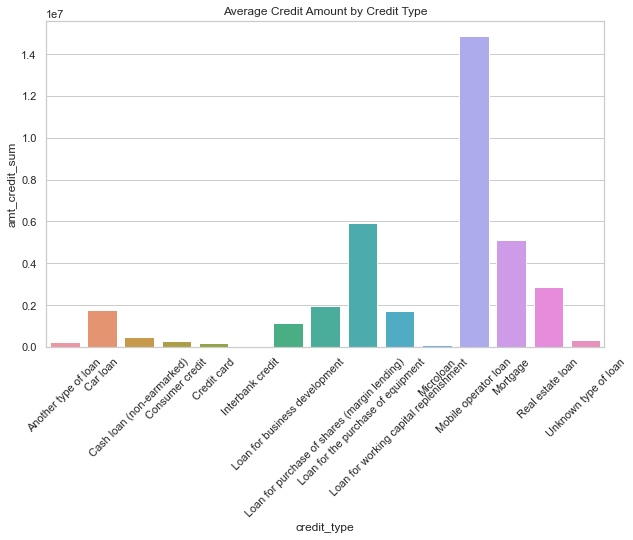

In [26]:
# Bar plot for average credit by type
plt.figure(figsize=(10, 6))
sns.barplot(x='credit_type', y='amt_credit_sum', data=avg_credit_by_type.reset_index())
plt.title('Average Credit Amount by Credit Type')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Another type of loan'),
  Text(1, 0, 'Car loan'),
  Text(2, 0, 'Cash loan (non-earmarked)'),
  Text(3, 0, 'Consumer credit'),
  Text(4, 0, 'Credit card'),
  Text(5, 0, 'Interbank credit'),
  Text(6, 0, 'Loan for business development'),
  Text(7, 0, 'Loan for purchase of shares (margin lending)'),
  Text(8, 0, 'Loan for the purchase of equipment'),
  Text(9, 0, 'Loan for working capital replenishment'),
  Text(10, 0, 'Microloan'),
  Text(11, 0, 'Mobile operator loan'),
  Text(12, 0, 'Mortgage'),
  Text(13, 0, 'Real estate loan'),
  Text(14, 0, 'Unknown type of loan')])

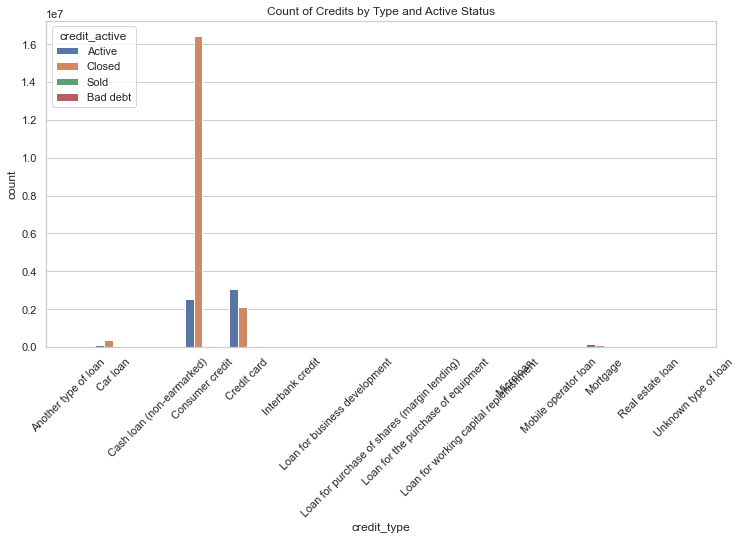

In [27]:
# Bar plot for count of credits
plt.figure(figsize=(12, 6))
sns.barplot(x='credit_type', y='count', hue='credit_active', data=count_credits)
plt.title('Count of Credits by Type and Active Status')
plt.xticks(rotation=45)

In [28]:
# using Z-score for Credit Amount, for outlier detection
merged_data['credit_amount_z_score'] = np.abs(stats.zscore(merged_data['amt_credit_sum']))
outliers = merged_data[merged_data['credit_amount_z_score'] > 3]

##### Data cleaning and Feature engineering

In [29]:
# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_cols = previous_credits.select_dtypes(include=[np.number]).columns
previous_credits[numerical_cols] = num_imputer.fit_transform(previous_credits[numerical_cols])

In [30]:
# Handling missing values for categorical columns
categorical_cols = previous_credits.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    previous_credits[col].fillna(previous_credits[col].mode()[0], inplace=True)

In [31]:
# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = ohe.fit_transform(previous_credits[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names(categorical_cols))
previous_credits = previous_credits.drop(columns=categorical_cols).join(encoded_features_df)

In [32]:
# Winsorization to cap outliers in numerical columns
for col in numerical_cols:
    previous_credits[col] = winsorize(previous_credits[col], limits=[0.05, 0.05])

In [33]:
# Feature Engineering on credit_bureau_balance data
# Replace 'X' with None and encode other statuses as increasing integers
credit_bureau_balance['status'].replace({'X': None, 'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}, inplace=True)
# Calculate loan score
credit_bureau_balance['loan_score'] = credit_bureau_balance['status'] / (abs(credit_bureau_balance['months_balance']) + 1)
loan_score = credit_bureau_balance.groupby('sk_id_bureau')['loan_score'].sum().rename('loan_score').reset_index()

# Merge the loan score into previous_credits
previous_credits = previous_credits.merge(loan_score, on='sk_id_bureau', how='left')

# Encoding categorical 'status' into dummy variables
credit_bureau_balance = pd.get_dummies(credit_bureau_balance, columns=['status'], prefix='status')

# Aggregate bureau balance data
credit_bureau_balance = credit_bureau_balance.groupby('sk_id_bureau').agg('mean')
credit_bureau_balance['MONTH_COUNT'] = credit_bureau_balance.groupby('sk_id_bureau')['months_balance'].count()

# Merge aggregated bureau balance data into previous_credits
previous_credits = previous_credits.merge(credit_bureau_balance, on='sk_id_bureau', how='left')

# Feature Engineering on previous_credits data
# Amount ratios
previous_credits['AMT_SUM_OVERDUE_RATIO'] = previous_credits['amt_credit_sum_overdue'] / previous_credits['amt_credit_sum']
previous_credits['AMT_MAX_OVERDUE_RATIO'] = previous_credits['amt_credit_max_overdue'] / previous_credits['amt_credit_sum']
previous_credits['AMT_SUM_DEBT_RATIO'] = previous_credits['amt_credit_sum_debt'] / previous_credits['amt_credit_sum']

# Log transformations
log_vars = ['amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit', 'amt_credit_sum_overdue', 'amt_annuity']
for var in log_vars:
    previous_credits['log_' + var] = np.log1p(previous_credits[var])

# Convert days to positive values and years
days_cols = ['days_credit', 'credit_day_overdue', 'days_credit_enddate', 'days_enddate_fact', 'days_credit_update']
for col in days_cols:
    previous_credits[col] = np.abs(previous_credits[col]) / 365

# Detect and handle outliers for 'amt_credit_sum'
z_scores = np.abs(stats.zscore(previous_credits['amt_credit_sum']))
previous_credits['amt_credit_sum'] = np.where(z_scores > 3, previous_credits['amt_credit_sum'].median(), previous_credits['amt_credit_sum'])

# Aggregate features
agg_features = {
    'amt_credit_sum': ['mean', 'sum', 'max'],
    'amt_credit_sum_debt': ['mean', 'sum', 'max'],
    'amt_credit_sum_overdue': ['mean', 'sum', 'max'],
    'amt_annuity': ['mean', 'sum', 'max'],
    'sk_id_curr': ['size']
}

previous_credits = previous_credits.groupby('sk_id_curr').agg(agg_features)
previous_credits.columns = ['_'.join(col).upper() for col in previous_credits.columns.values]


# 3. Bank X loan history section

In [34]:
merged_data = pd.merge(previous_loan_applications, repayment_history, on='sk_id_curr', how='inner')

In [35]:
merged_data = downcaste_dtype(merged_data)

Memory usage before downcasting: 19942.53 MB
After Downcasting the memory usage decreased to: 19942.53 MB
Memory usage decreased by 0.000%


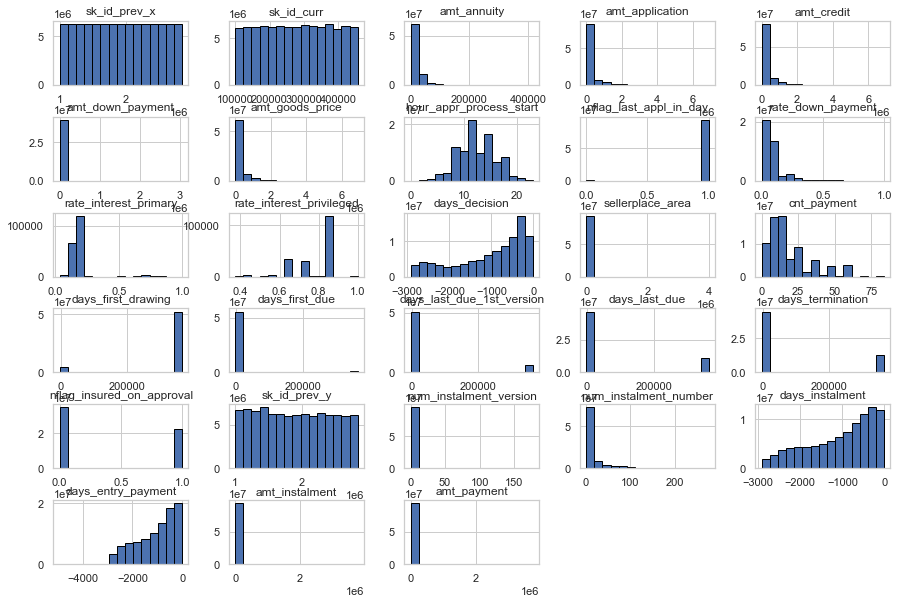

In [36]:
# Distribution of key numerical features
merged_data.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 'Distribution of Loan Amounts')

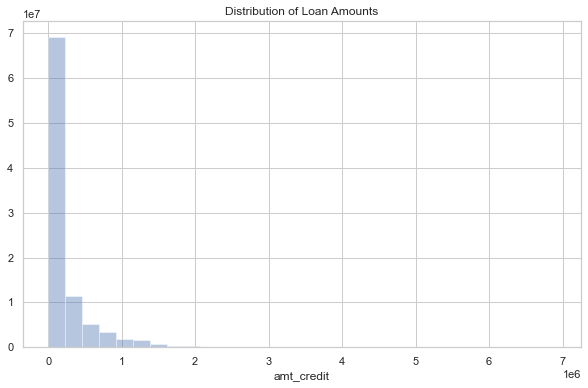

In [37]:
#Loan Amount Distribution
plt.figure(figsize=(10, 6))
sns.distplot(merged_data['amt_credit'], bins=30, kde=False)
plt.title('Distribution of Loan Amounts')

In [38]:
# # Correlation analysis
# correlation_matrix = merged_data.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')

In [39]:
# Average loan amount by contract status
avg_loan_by_status = merged_data.groupby('name_contract_status')['amt_credit'].mean()

# Total payment by loan type
total_payment_by_type = merged_data.groupby('name_contract_type')['amt_payment'].sum()

# Count of loan applications by client
count_loans_by_client = merged_data.groupby('sk_id_curr').size().reset_index(name='loan_count')

# Average loan amount and total payment by contract status
agg_data = merged_data.groupby('name_contract_status').agg({'amt_credit': 'mean', 
                                                           'amt_payment': 'sum'}).reset_index()

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Approved'),
  Text(1, 0, 'Canceled'),
  Text(2, 0, 'Refused'),
  Text(3, 0, 'Unused offer')])

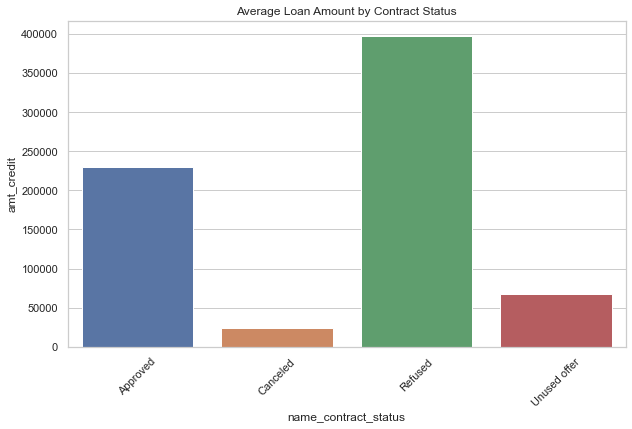

In [40]:
# Bar plot for average loan amount by status
plt.figure(figsize=(10, 6))
sns.barplot(x='name_contract_status', y='amt_credit', data=avg_loan_by_status.reset_index())
plt.title('Average Loan Amount by Contract Status')
plt.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Cash loans'),
  Text(1, 0, 'Consumer loans'),
  Text(2, 0, 'Revolving loans'),
  Text(3, 0, 'XNA')])

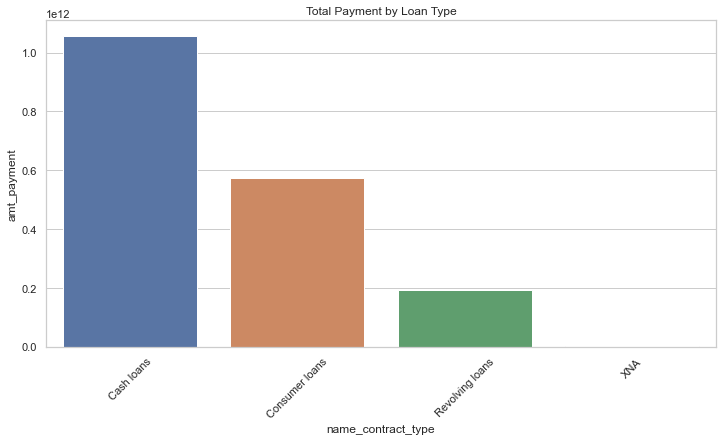

In [41]:
# Bar plot for total payment by loan type
plt.figure(figsize=(12, 6))
sns.barplot(x='name_contract_type', y='amt_payment', data=total_payment_by_type.reset_index())
plt.title('Total Payment by Loan Type')
plt.xticks(rotation=45)

In [42]:
# # detecting outliers, using z-score 
# merged_data['loan_amount_z_score'] = np.abs(stats.zscore(merged_data['amt_credit']))
# outliers = merged_data[merged_data['loan_amount_z_score'] > 3]
# outliers

In [45]:
merged_data.shape

(94194869, 44)

##### Data cleaning and Feature engineering

In [43]:
# Handling missing values for numerical columns with median imputation
num_imputer = SimpleImputer(strategy='mean')
numerical_cols = merged_data.select_dtypes(include=[np.number]).columns
merged_data[numerical_cols] = num_imputer.fit_transform(merged_data[numerical_cols])

MemoryError: Unable to allocate 19.7 GiB for an array with shape (28, 94194869) and data type float64

In [44]:
# Handling missing values for categorical columns with mode imputation
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = merged_data.select_dtypes(include=['object', 'category']).columns
merged_data[categorical_cols] = cat_imputer.fit_transform(merged_data[categorical_cols])

MemoryError: Unable to allocate 11.2 GiB for an array with shape (94194869, 16) and data type object

In [ ]:
# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = ohe.fit_transform(merged_data[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names(categorical_cols))
merged_data = merged_data.drop(columns=categorical_cols).join(encoded_features_df)

In [ ]:
# Feature Engineering for Repayment History

# Days past due and days before due (no negative values)
merged_data['DPD'] = merged_data['days_entry_payment'] - merged_data['days_instalment']
merged_data['DBD'] = merged_data['days_instalment'] - merged_data['days_entry_payment']
merged_data['DPD'] = merged_data['DPD'].apply(lambda x: x if x > 0 else 0)
merged_data['DBD'] = merged_data['DBD'].apply(lambda x: x if x > 0 else 0)

# Percentage and difference paid in each installment 
merged_data['PAYMENT_PERC'] = merged_data['amt_payment'] / merged_data['amt_instalment']
merged_data['PAYMENT_DIFF'] = merged_data['amt_instalment'] - merged_data['amt_payment']

# Logarithms for installment and payment amounts
log_vars = ["amt_instalment", "amt_payment"]
for var in log_vars:
    merged_data['log_' + var] = np.log1p(merged_data[var])

# Feature Engineering for Previous Loan Applications

# Amount ratios
merged_data["AMT_GIVEN_RATIO_1"]  = merged_data["amt_credit"] / merged_data["amt_application"]
merged_data["AMT_GIVEN_RATIO_2"]  = merged_data["amt_goods_price"] / merged_data["amt_application"]
merged_data["DOWN_PAYMENT_RATIO"] = merged_data["amt_down_payment"] / merged_data["amt_application"]

# Convert days to positive values and years
day_vars = ["days_decision", "days_first_drawing", "days_first_due", "days_last_due_1st_version", 
            "days_last_due", "days_termination"]
for col in day_vars:
    merged_data[col] = np.abs(merged_data[col]) / 365

# Dummy encoding for categorical variables
categorical_cols = merged_data.select_dtypes(include=['object', 'category']).columns
merged_data = pd.get_dummies(merged_data, columns=categorical_cols, drop_first=True)

# Aggregations for Repayment History
agg_repayment = merged_data.groupby('sk_id_curr').agg({
    'DPD': ['mean', 'max'],
    'DBD': ['mean', 'max'],
    'PAYMENT_PERC': ['mean', 'min', 'max'],
    'PAYMENT_DIFF': ['mean', 'sum']
}).add_prefix('repayment_')

# Aggregations for Previous Loan Applications
agg_prev_loan = merged_data.groupby('sk_id_curr').agg({
    'AMT_GIVEN_RATIO_1': 'mean',
    'AMT_GIVEN_RATIO_2': 'mean',
    'DOWN_PAYMENT_RATIO': 'mean',
}).add_prefix('prev_loan_')

# Combining Aggregated Data
final_agg = pd.concat([agg_repayment, agg_prev_loan], axis=1)

# 4. Consumer Credit and Loan Products Section

In [ ]:
merged_data = pd.merge(pos_cash_loans, credit_cards, on='sk_id_curr', how='inner')

In [ ]:
# Distribution of key numerical features
merged_data.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

In [ ]:
# Advanced Visualization: POS Cash Loan Amount Distribution
plt.figure(figsize=(10, 6))
sns.distplot(pos_cash_loans['cnt_instalment_future'], bins=30, kde=False)
plt.title('Distribution of Future Installments Count in POS Cash Loans')

In [ ]:
# Average balance by contract status in credit cards
avg_balance_by_status = credit_cards.groupby('name_contract_status')['amt_balance'].mean()

# Total POS cash loan count by contract status
total_pos_count_by_status = pos_cash_loans.groupby('name_contract_status').size().reset_index(name='count')

# Multi-level aggregation
# Average balance and total credit limit by contract status in credit cards
agg_data = credit_cards.groupby('name_contract_status').agg({'amt_balance': 'mean', 
                                                             'amt_credit_limit_actual': 'sum'}).reset_index()

In [ ]:
# Bar plot for average balance by contract status
plt.figure(figsize=(10, 6))
sns.barplot(x='name_contract_status', y='amt_balance', data=avg_balance_by_status.reset_index())
plt.title('Average Balance by Contract Status in Credit Cards')
plt.xticks(rotation=45)

In [ ]:
# Bar plot for total POS cash loan count by status
plt.figure(figsize=(12, 6))
sns.barplot(x='name_contract_status', y='count', data=total_pos_count_by_status)
plt.title('Total POS Cash Loan Count by Contract Status')
plt.xticks(rotation=45)

In [ ]:
# outliers detections usgin z-score
credit_cards['balance_z_score'] = np.abs(stats.zscore(credit_cards['amt_balance']))
outliers = credit_cards[credit_cards['balance_z_score'] > 3]
outliers

##### Data cleaning and Feature engineering

In [ ]:
# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='median')
numerical_cols = merged_data.select_dtypes(include=[np.number]).columns
merged_data[numerical_cols] = num_imputer.fit_transform(merged_data[numerical_cols])

In [ ]:
# Handling missing values for categorical columns with mode imputation
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = merged_data.select_dtypes(include=['object', 'category']).columns
merged_data[categorical_cols] = cat_imputer.fit_transform(merged_data[categorical_cols])

In [ ]:
# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = ohe.fit_transform(merged_data[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names(categorical_cols))
merged_data = merged_data.drop(columns=categorical_cols).join(encoded_features_df)

In [ ]:
# Feature Engineering for POS Cash Loans


# Installments percentage
merged_data["INSTALLMENTS_PERCENT"] = merged_data["cnt_instalment_future"] / merged_data["cnt_instalment"]

# Dummy encoding for POS Cash Loans
merged_data = pd.get_dummies(merged_data, columns=['name_contract_status_pos'], drop_first=True)

# Aggregations for POS Cash Loans
cnt_mon_pos = merged_data[["sk_id_prev_pos", "months_balance_pos"]].groupby("sk_id_prev_pos").count()
merged_data["POCA_MONTH_COUNT"] = merged_data["sk_id_prev_pos"].map(cnt_mon_pos["months_balance_pos"])
agg_poca = merged_data.groupby("sk_id_curr").agg({'INSTALLMENTS_PERCENT': ['mean', 'max'], 
                                                  'POCA_MONTH_COUNT': ['mean', 'sum']})

# Feature Engineering for Credit Cards
# Logarithmic transformations
col_log = ["amt_balance", "amt_credit_limit_actual", "amt_drawings_atm_current", "amt_drawings_current",
                 "amt_drawings_other_current", "amt_drawings_pos_current", "amt_inst_min_regularity",
                 "amt_payment_current", "amt_payment_total_current", "amt_receivable_principal",
                 "amt_recivable", "amt_total_receivable"]
for var in col_log:
    merged_data['log_' + var] = np.log1p(merged_data[var])

# Dummy encoding for Credit Cards
merged_data = pd.get_dummies(merged_data, columns=['name_contract_status_card'], drop_first=True)

# Aggregations for Credit Cards
cnt_mon_card = merged_data[["sk_id_prev_card", "months_balance_card"]].groupby("sk_id_prev_card").count()
merged_data["CARD_MONTH_COUNT"] = merged_data["sk_id_prev_card"].map(cnt_mon_card["months_balance_card"])
agg_card = merged_data.groupby("sk_id_curr").agg({var: ['mean', 'sum', 'max'] for var in col_log})
agg_card.columns = ['_'.join(col).upper() for col in agg_card.columns.values]

# Combine Aggregations
final_agg = pd.concat([agg_poca, agg_card], axis=1)